# Horror Films Bring in Scary High ROIs 

#### Authors and Contact Information: [Madeleine Smithers](https://github.com/MaddieSmithers) [(Technical Lead)](https://www.linkedin.com/in/madeleinesmithers/034123/), [Lillian Lakes](https://github.com/lillianlakes) [(GitHub Lead)](https://www.linkedin.com/in/lillianlakes/) and [Stuart Clark](https://github.com/sclarkHOUis-project/tree/Stuart) [(Presentation Lead)](https://www.linkedin.com/in/stuart-clark-185034123/)

![IT](images/IT_Header.png)

## Overview 

This project presents an analysis of past film data that aims to provide concrete recommendations to Thunderhouse Films, an emerging film studio. It analyzes production budgets, box office revenue, genres, and release times in order to predict the most profitable strategy for producing and releasing films. Descriptive analysis and regression analysis of production budget and gross sales data show that horror films in the mid-budget range bring in the highest returns on investment, especially when released in the weeks leading to Halloween. Thunderhouse films can use our analysis to target movies with the highest ROI as they launch their new movie studio and later expand.

## Business Problem

Entering the movie business requires a certain level of risk and capital allocation. By analyzing data of past films, we hope to devise a strategy that will make the most effective use of each dollar our client spends as a new film studio. The most important metric in this case is the Return on Investment (ROI) from each film, since producing a film is an expensive endeavor and we want to ensure the payoff is maximized. We saw three main categories that a new entrant into the industry would need to consider. These include how much to spend on a film, what genre to produce, and when to release the film. We first start off by segmenting the market into low, mid, and high-budget films, as these three segments all differ in their optimal strategy. We then use the main genre associated with each film to look across our market segments for the highest median ROI, in order to account for outliers. Finally, we assess the best time to release a film by analyzing our top genre across each month of the year to find where films repeatedly yield high returns.

## Data Understanding

Our initial data comprised of datasets from [Box Office Mojo](https://www.boxofficemojo.com/), [IMDB](https://www.imdb.com/), [Rotten Tomatoes](https://www.rottentomatoes.com/), [TheMovieDB](https://www.themoviedb.org/), and [The Numbers](https://www.the-numbers.com/). For our specific goals of analyzing budget ranges, genres, and release dates, we decided to use data from The Numbers and IMDB, as these were the most informative and robust for our purposes. We did notice limitations in our available data from the beginning, including the lack of additional revenue streams outside of the box office, missing information on costs to produce films which would have complemented production budget data, and not accounting for inflation. After appropriate data cleaning and exploration, we decided to filter out films that were not released theatrically since we could only compare revenue from the box office. We also decided to only use data on films released between 2010 and 2020, since this window is where we had the most reliable data.

## Data Preparation 

In [164]:
#import all necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import math
import sqlite3
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [165]:
#import original datasets
movie = pd.read_csv('data/zippedData/tmdb.movies.csv.gz')
movie_info = pd.read_csv('data/zippedData/rt.movie_info.tsv.gz',sep='\t', compression='gzip')
movie_review = pd.read_csv('data/zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1')
movie_gross = pd.read_csv('data/zippedData/bom.movie_gross.csv.gz')
movie_budget = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

#specify the path to the zip file
zip_file_path = 'data/zippedData/im.db.zip'

#Extract the SQLite database file from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('unzippedData')

#connect to extracted SQLite database
database_path = 'unzippedData/im.db'
conn = sqlite3.connect(database_path)

#### Clean up movie_budget dataset

In [166]:
# convert "release_date" column to datetime format
movie_budget["release_date"] = pd.to_datetime(movie_budget["release_date"])

# create "year" and "month" columns from "release_date" column
movie_budget["release_year"] = movie_budget["release_date"].dt.year
movie_budget["release_month"] = movie_budget["release_date"].dt.month

# convert "production_budget", "domestic_gross" and "worldwide_gross" columns to int64 format
movie_budget["production_budget"] = movie_budget["production_budget"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["domestic_gross"] = movie_budget["domestic_gross"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["worldwide_gross"] = movie_budget["worldwide_gross"].str.replace(",", "").str.replace("$", "").astype("int64")

#drop columns where worldwide gross is 0, since they were not released theatrically 
movie_budget = movie_budget[movie_budget['worldwide_gross'] != 0]

# create "foreign_gross" column by subtracting "domestic_gross" from "worldwide_gross"
movie_budget["foreign_gross"] = movie_budget["worldwide_gross"] - movie_budget["domestic_gross"]

# create "total_profit" column by subtracting "worldwide_gross" from "production_budget"
movie_budget["total_profit"] = movie_budget["worldwide_gross"] - movie_budget["production_budget"]

#create "ROI" column by dividing "worldwide_gross" by "production_budget" 
movie_budget['ROI'] = (movie_budget['worldwide_gross'] / movie_budget['production_budget']) * 100

#### Merge movie_budget with movie_basics from SQL database

In [167]:
#import movie_basics from SQL Database
movie_basics = pd.read_sql("""
SELECT primary_title, genres
FROM movie_basics
""",conn)

conn.close()

movie_basics.drop_duplicates(subset="primary_title", keep="last", inplace=True)

# merge movie_basics and movie_budget on movie and primary_title
movie_df = pd.merge(movie_basics, movie_budget, left_on="primary_title", right_on="movie", how="inner")

#drop films before 2010
movie_df = movie_df[movie_df["release_year"] >= 2010]

#reorder columns
movie_df = movie_df[["movie", "genres", 'release_month', 'release_year', "production_budget", "domestic_gross", "foreign_gross", "worldwide_gross", "total_profit", "ROI"]]

#### Create Master Dataset

In [168]:
#feature engineer a column for budget range
def budget(x): 
    if x < 5000000: 
        budget = 'low'
    if 5000000 <= x < 50000000: 
        budget = 'mid'
    if x >= 50000000:
        budget = 'high'
    return budget

movie_df['budget'] = movie_df['production_budget'].apply(lambda x: budget(x))

In [169]:
#drop null genres
movie_df.dropna(subset='genres', inplace=True)

#create main genre column
def get_main_genre(x):
    genres = x.split(',')
    main_genre = genres[0]
    return main_genre
movie_df['main_genre'] = movie_df['genres'].apply(lambda x: get_main_genre(x))

In [170]:
#create subgenres column
def get_subgenres(x):
    genres = x.split(',')
    sub_genres = genres[1:]
    return sub_genres
movie_df['subgenres'] = movie_df['genres'].apply(lambda x: get_subgenres(x))

In [171]:
#reorder columns
movie_df = movie_df[["movie", "genres", 'main_genre', 'subgenres', 'release_month', 'release_year', 'budget', "production_budget", "domestic_gross", "foreign_gross", "worldwide_gross", "total_profit", "ROI"]]

In [172]:
#reset index
movie_df.reset_index(inplace=True)
movie_df.drop('index', axis =1, inplace=True)

# Write the DataFrame to a CSV file
movie_df.to_csv('data/movie_data.csv', index=False)

In [173]:
#read in our master dataset
movie_data = pd.read_csv('data/movie_data.csv')

## Data Visualization

In [174]:
#separate data by budget range
data_high = movie_data[movie_data['budget'] == 'high']
data_mid = movie_data[movie_data['budget'] == 'mid']
data_low = movie_data[movie_data['budget'] == 'low']

#### Plot Median ROI by Genre (Separated by Budget Range)

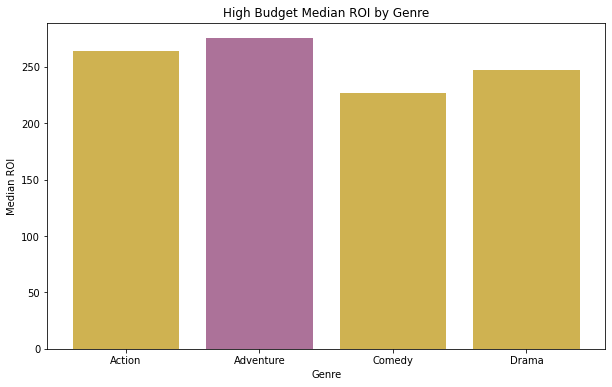

In [175]:
#drop genres that don't have enough values to analyze 
s = data_high.groupby('main_genre')['ROI'].count().sort_values(ascending=False)
high_ROI_filtered = (s.drop(s[s < 15].index)).index

high_genre_ROIs = data_high.groupby('main_genre')['ROI'].median().loc[high_ROI_filtered]

#plot bar graph for high-budget median ROI by genre
x = high_genre_ROIs.index
y = high_genre_ROIs.values
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(x, y, color = '#CFB251')
plt.bar(x[1], y[1], color = '#AC7299')
ax.set_title("High Budget Median ROI by Genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Median ROI");

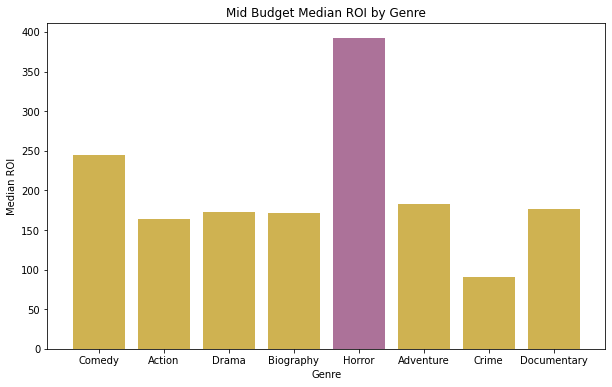

In [176]:
#drop genres that don't have enough values to analyze 
s = data_mid.groupby('main_genre')['ROI'].count().sort_values(ascending=False)
mid_ROI_filtered = (s.drop(s[s < 15].index)).index

mid_genre_ROIs = data_mid.groupby('main_genre')['ROI'].median().loc[mid_ROI_filtered]

#plot bar graph for mid-budget median ROI by genre
x = mid_genre_ROIs.index
y = mid_genre_ROIs.values
fig, ax = plt.subplots(figsize=(10,6))
plt.bar(x, y, color = '#CFB251')
plt.bar(x[4], y[4], color = '#AC7299')
ax.set_title("Mid Budget Median ROI by Genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Median ROI");

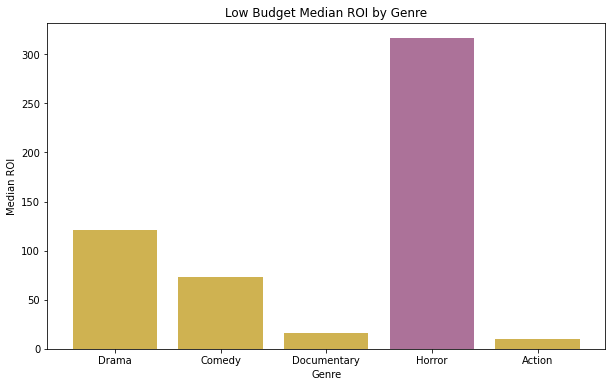

In [177]:
#drop genres that don't have enough values to analyze 
s = data_low.groupby('main_genre')['ROI'].count().sort_values(ascending=False)
low_ROI_filtered = (s.drop(s[s < 15].index)).index

low_genre_ROIs = data_low.groupby('main_genre')['ROI'].median().loc[low_ROI_filtered]

#plot bar graph for mid-budget median ROI by genre
x = low_genre_ROIs.index
y = low_genre_ROIs.values
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(x, y, color = '#CFB251')
plt.bar(x[3], y[3], color = '#AC7299')
ax.set_title("Low Budget Median ROI by Genre")
ax.set_xlabel("Genre")
ax.set_ylabel("Median ROI");


#### Plot median ROI by release month for mid-budget horror films
By comparing our values from above, we find that the highest median ROI comes from the mid-budget horror category. We now want to explore which month tends to have the highest ROI.

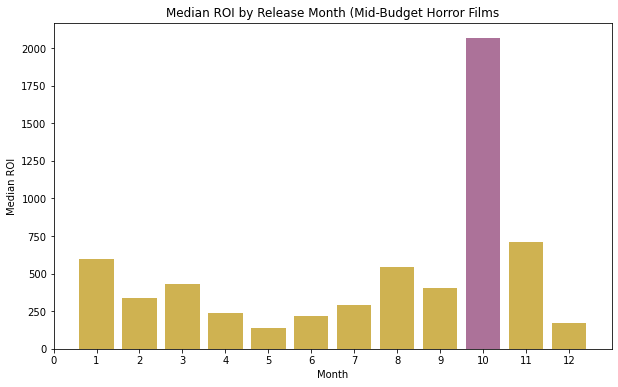

In [178]:
#group by month and bar chart 
mid_horror = data_mid[data_mid['main_genre'] == 'Horror']

horror_by_month = mid_horror.groupby('release_month')['ROI'].median()
x = horror_by_month.index
y = horror_by_month.values
fig, ax = plt.subplots(figsize = (10,6))
plt.bar(x, y, color = '#CFB251')
plt.bar(x[9], y[9], color = '#AC7299')
ax.set_xlabel("Month")
ax.set_ylabel("Median ROI")
ax.set_xticks(range(13))
ax.set_title("Median ROI by Release Month (Mid-Budget Horror Films");


## Linear Regression

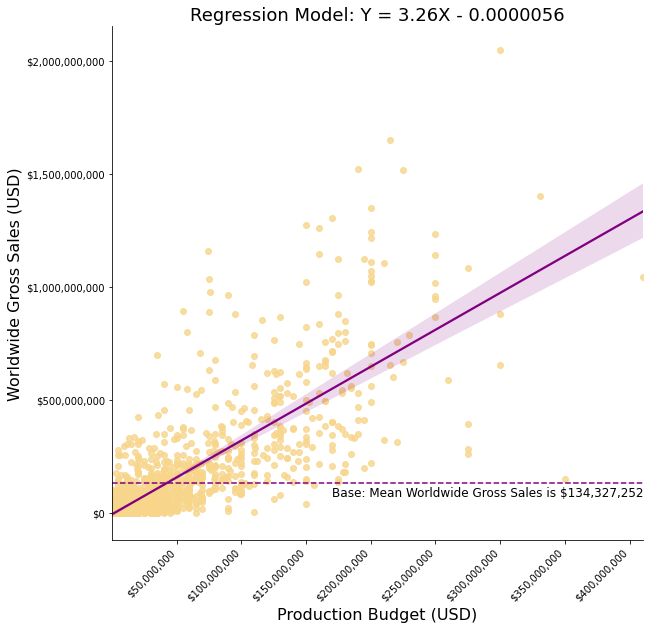

In [179]:
import matplotlib.ticker as ticker

# Plot the scatterplot
lm = sns.lmplot(x='production_budget', y='worldwide_gross', data=movie_data, height=8, aspect=1, scatter_kws= {'color': '#f7d58b'}, line_kws={'color': 'purple'})
  
ax = lm.ax

# Set label for x-axis
ax.set_xlabel( "Production Budget (USD)" , size = 16 )
  
# Set label for y-axis
ax.set_ylabel( "Worldwide Gross Sales (USD)" , size = 16 )
  
# Set title for plot
ax.set_title( "Regression Model: Y = 3.26X - 0.0000056" , size = 18 )

# Rotate the x-tick labels
ax.set_xticklabels(x, rotation=45, ha='right')

# Add a base model that predicts the worldwide gross sales from the mean
xmin, xmax = plt.xlim()

plt.hlines(y=movie_data['worldwide_gross'].mean(),
           xmin=xmin, xmax=xmax,
           colors=['purple'],
           linestyles={'dashed'})
plt.text(xmax, movie_data['worldwide_gross'].mean()-15000000, 
         f'Base: Mean Worldwide Gross Sales is ${movie_data["worldwide_gross"].mean():,.0f}', 
         fontsize=12, ha='right', va='top')

# Format the x- and y-axis labels
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
  
# Display figure
plt.show()

In [180]:
X = movie_data['production_budget'].values
y = movie_data.worldwide_gross.values

model = sm.OLS(y, X, hasconst=False) # creating our model

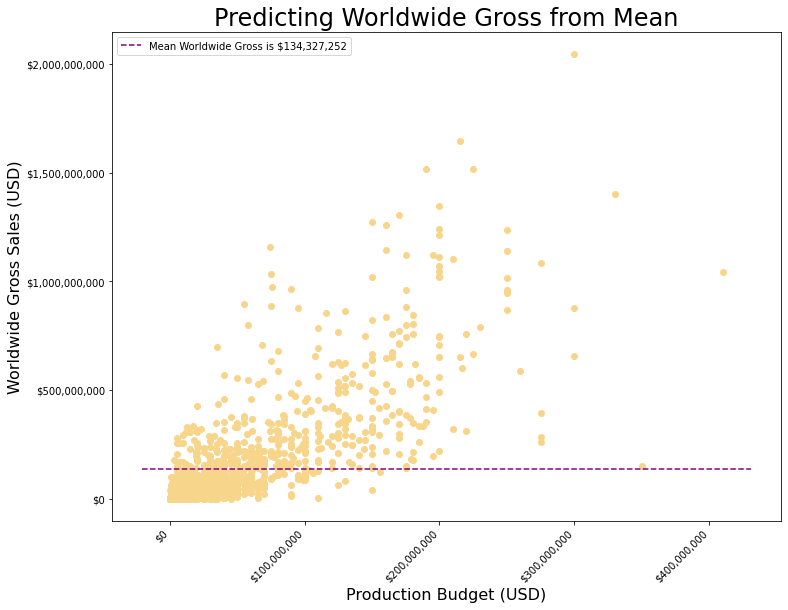

In [181]:
# Baseline model -- use the mean of y as a baseline 

fig, ax = plt.subplots(figsize=(12, 9))

# plt.scatter(movie_data['production_budget'], movie_data['worldwide_gross'])

ax.scatter(movie_data['production_budget'], movie_data['worldwide_gross'], color='#f7d58b')

xmin, xmax = plt.xlim()

plt.hlines(y=movie_data['worldwide_gross'].mean(),
           xmin=xmin, xmax=xmax,
           colors=['purple'],
           linestyles={'dashed'},
           label=f'Mean Worldwide Gross is ${movie_data["worldwide_gross"].mean():,.0f}')

# plt.title('Predicting Worldwide Gross from Mean')

# # Set label for x-axis
ax.set_xlabel( "Production Budget (USD)" , size = 16 )

# # Set label for y-axis
ax.set_ylabel( "Worldwide Gross Sales (USD)" , size = 16 )
  
# # Set title for plot
ax.set_title( "Predicting Worldwide Gross from Mean" , size = 24 )

ax.set_xticklabels(x, rotation=45, ha='right')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.legend()
plt.show()


In [182]:
model = sm.OLS(y, X, hasconst=False) # creating our model
results = model.fit() # actually fitting the model
results.params # seeing our coefficients

array([3.21285847])

In [183]:
results.predict([0, 2, 4]) # predicting for some random possible X values

array([ 0.        ,  6.42571693, 12.85143386])

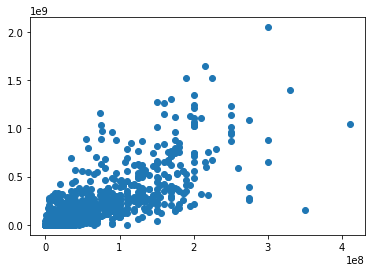

In [184]:
plt.scatter(movie_data['production_budget'], movie_data['worldwide_gross'])

x_pred_range = np.linspace(0, 4, 4)
plt.plot(x_pred_range, results.predict(x_pred_range))

plt.show()

In [185]:
X_with_const = sm.add_constant(X) # easiest way to add the constant
pd.DataFrame(X_with_const, columns=['ones', 'production_budget']).head() # showing the change

,ones,production_budget
0,1.0,45000000.0
1,1.0,91000000.0
2,1.0,28000000.0
3,1.0,215000000.0
4,1.0,45000000.0


In [186]:
model2 = sm.OLS(y, X_with_const, hasconst=True)
results2 = model2.fit()
results2.params

array([-5.63124836e+06,  3.26279701e+00])

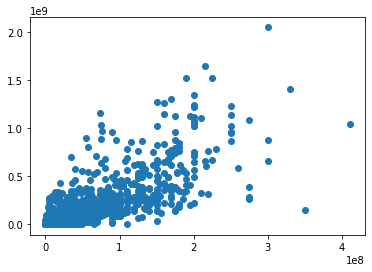

In [187]:
plt.scatter(movie_data['production_budget'], movie_data['worldwide_gross'])

x_pred_range = np.linspace(0, 4, 4)
plt.plot(x_pred_range, results2.predict(sm.add_constant(x_pred_range)))

plt.show()

#### Model Evaluation

In [188]:
# Summary of regression results for model with a constant
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     2542.
Date:                Sun, 25 Jun 2023   Prob (F-statistic):               0.00
Time:                        15:12:14   Log-Likelihood:                -32031.
No. Observations:                1587   AIC:                         6.407e+04
Df Residuals:                    1585   BIC:                         6.408e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.631e+06    4.5e+06     -1.251      0.211   -1.45e+07     3.2e+06
x1             3.2628      0.065     50.414      0.000       3.136       3.390
==============================================================================
Omnibus:                      780.042   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12952.413
Skew:                           1.882   Prob(JB):                         0.00
Kurtosis:                      16.480   Cond. No.                     8.84e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.84e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our linear regression model tells us that production budget accounts for approximately 62% of the variation in worldwide gross sales across our dataset. In other words, every $1,000,000 increase in production budget results in an approximately $3,260,000 increase in worldwide gross sales. 

## Conclusion
From our analysis of the data provided, we can conclude that horror movies in the mid-budget range released in the month of October will most likely have the highest ROI. From looking at our regression model, we can also conclude that a high production budget has a signficant impact on worldwide gross sales. 

However, a new film studio might not be prepared to take on the financial risks associated with high budget films. Therefore, we can confidently recommend a new film studio to start with low-budget horror films, as the horror genre still performed the best in terms of ROI for the low-budget range. This way, the studio can gain experience in the industry comfortability with their production and release strategies before taking on more expensive horror projects. 

With more experience, Thunderhouse Films can aspire to create box office successes such as the movie, It, which was the highest grossing horror movie between 2010 and 2019, with a production budget of only $35 million. 

## Future Steps
In order to account for the previously mentioned data limitations, we would like to continue our analysis with more information on the costs and revenue streams associated with producing and releasing a film. We would want to look at costs such as distribution, studio overhead, and marketing. Additional revenue streams to explore might include DVD sales, streaming, and licensing deals. Through this, we could get a more accurate look at the ROI of each film. 

In addition, we would like to further analyze some of the most successful horror films to find out what made them such box office hits. Factors such as marketing strategy, source material, or creators involved could prove very insightful.